In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pymoo.problems.single.flowshop_scheduling import create_random_flowshop_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize



In [2]:
g = nx.Graph()
g.add_edges_from([(1,2),(2,3)])

g.edges

EdgeView([(1, 2), (2, 3)])

### Testando Problema de Job Scheduling

In [3]:
problem = create_random_flowshop_problem(n_machines=5, n_jobs=10, seed=1)

algorithm = GA(
    pop_size=20,
    eliminate_duplicates=True,
    sampling=PermutationRandomSampling(),
    mutation=InversionMutation(),
    crossover=OrderCrossover()
)

termination = DefaultSingleObjectiveTermination(period=50, n_max_gen=10000)

res = minimize(
    problem,
    algorithm,
    termination,
    seed=1
)

[[9 3 6 7 8 2 4 0 1 5]
 [2 3 6 9 1 8 5 7 0 4]
 [0 8 2 6 1 3 4 5 9 7]
 [4 7 0 1 2 9 8 5 6 3]
 [4 5 6 0 7 9 3 2 8 1]
 [5 4 9 6 0 1 8 7 2 3]
 [7 6 5 0 4 9 3 2 8 1]
 [2 7 4 3 6 9 1 8 5 0]
 [0 8 6 4 2 9 7 5 1 3]
 [6 4 3 5 2 0 8 9 1 7]
 [2 4 3 0 6 9 7 8 1 5]
 [2 9 6 4 0 3 1 7 8 5]
 [0 3 5 9 8 4 2 1 6 7]
 [2 7 4 0 1 6 3 5 9 8]
 [4 3 5 6 0 1 8 7 2 9]
 [4 5 0 9 3 6 1 7 8 2]
 [6 7 9 2 8 1 3 5 0 4]
 [2 3 6 7 4 0 9 8 1 5]
 [6 4 2 9 0 3 1 7 8 5]
 [2 4 3 0 6 1 5 8 7 9]]
[[2 9 6 4 0 5 3 1 7 8]
 [2 9 6 4 0 3 1 7 8 5]
 [2 4 3 0 6 1 5 8 7 9]
 [2 4 3 0 6 9 8 7 1 5]
 [6 4 7 5 2 0 8 9 1 3]
 [2 3 4 0 6 1 5 8 9 7]
 [4 0 6 1 7 2 3 5 9 8]
 [3 6 9 7 1 8 2 5 0 4]
 [4 7 2 0 5 3 6 1 9 8]
 [7 9 8 6 4 5 0 3 2 1]
 [6 9 2 4 0 3 5 8 7 1]
 [2 3 6 9 1 8 5 7 0 4]
 [2 3 4 0 6 1 5 8 7 9]
 [6 9 5 7 4 3 1 8 2 0]
 [6 4 8 0 1 2 3 5 9 7]
 [2 3 6 9 1 8 5 7 4 0]
 [6 4 0 2 3 1 5 8 7 9]
 [6 3 2 0 4 9 8 7 1 5]
 [4 5 3 6 0 1 8 7 2 9]
 [4 5 6 0 7 9 8 2 1 3]]
[[4 3 6 1 2 0 5 8 7 9]
 [4 3 5 2 6 1 0 8 9 7]]
[[4 3 6 1 7 2 0 5 8 9]
 [2 4 0 

In [4]:
res.problem

Maximum Span: 1044.384
Function Evaluations: 1280


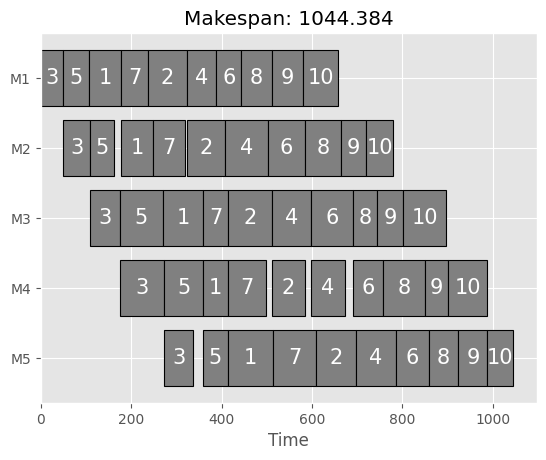

In [5]:
print("Maximum Span:", np.round(res.F[0], 3))
print("Function Evaluations:", res.algorithm.evaluator.n_eval)
from pymoo.problems.single.flowshop_scheduling import visualize
visualize(problem, res.X)

In [6]:
list1 = ['a', 'b', 'c', 'd', 'e', 'f']
list2 = [0, 0, 'g', 0, 'h', 'i']
ind = [0, 2, 3]

# Iterate over list2 and if the item is 0, replace it with the corresponding item from list1 using the indices from ind
ind_index = 0  # Initialize index for ind list
for i in range(len(list2)):
    if list2[i] == 0:
        list2[i] = list1[ind[ind_index]]  # Use the current index from ind
        ind_index += 1  # Move to the next index in ind list

print(list2)


['a', 'c', 'g', 'd', 'h', 'i']
